In [172]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from dateutil.relativedelta import relativedelta
import seaborn as sns
from wishpy.dataworker import DataWorker
dw = DataWorker(google_secret='../../../wishpy/client_secret.json')
import math

# from scipy import stats
from scipy.stats import chi2, chi2_contingency
import statsmodels.stats.api as sms

import ttd_experiment as ttd

%matplotlib inline

# Prepare the data

In [16]:
df_lrr = dw.td_query('''
'''
,job_id=725816212
                )

You can look at job id 725816212


In [81]:
df_cr = dw.td_query('''
'''
,job_id=725812197
,engine='presto'
                )

You can look at job id 725812197


In [90]:
df_uid = dw.td_query('''
    select (case 
          when groups = 'ttd_estimate_service_control' then 'ttd_estimate_service_control_30popu'
          when groups = 'ttd_estimate_service_show' then 'ttd_estimate_service_show_20p_80p_20popu'
          when groups = 'ttd_estimate_service_show-v2' then 'ttd_estimate_service_show_v2_10p_80p_10popu'
          when groups = 'ttd_estimate_service_show-v3' then 'ttd_estimate_service_show_v3_10p_60p_10popu'
          when groups = 'ttd_estimate_service_show-v4' then 'ttd_estimate_service_show_v4_20p_50p_10popu'
          when groups = 'ttd_estimate_service_show-v5' then 'ttd_estimate_service_show_v5_50p_70p_10popu'
          else 'other'
        end) as new_groups
        ,count(distinct user_id) as unique_uid_count
    from analytics.jay_ttd_exp_cr_20190522_20190709   
    where groups != 'other'
    group by 1
'''
 ,job_id=726012782
,engine='presto'
                )

You can look at job id 726012782


In [93]:
df_uid_dt = dw.td_query('''
    select (case 
          when groups = 'ttd_estimate_service_control' then 'ttd_estimate_service_control_30popu'
          when groups = 'ttd_estimate_service_show' then 'ttd_estimate_service_show_20p_80p_20popu'
          when groups = 'ttd_estimate_service_show-v2' then 'ttd_estimate_service_show_v2_10p_80p_10popu'
          when groups = 'ttd_estimate_service_show-v3' then 'ttd_estimate_service_show_v3_10p_60p_10popu'
          when groups = 'ttd_estimate_service_show-v4' then 'ttd_estimate_service_show_v4_20p_50p_10popu'
          when groups = 'ttd_estimate_service_show-v5' then 'ttd_estimate_service_show_v5_50p_70p_10popu'
          else 'other'
        end) as new_groups
        ,action_dt
        ,count(distinct user_id) as unique_uid_count
    from analytics.jay_ttd_exp_cr_20190522_20190709   
    where groups != 'other'
    group by 1,2
    order by 1,2
'''
#  ,job_id=726012782
,engine='presto'
                )

You can look at job id 726019953


In [94]:
df_uid_dt.head()

,new_groups,action_dt,unique_uid_count
0,ttd_estimate_service_control_30popu,2019-05-22,1658736
1,ttd_estimate_service_control_30popu,2019-05-23,1742753
2,ttd_estimate_service_control_30popu,2019-05-24,1867417
3,ttd_estimate_service_control_30popu,2019-05-25,1783269
4,ttd_estimate_service_control_30popu,2019-05-26,1784191


# validate uid bucket assignment and whether they are balanced or not

In [92]:
df_uid

,new_groups,unique_uid_count
0,ttd_estimate_service_show_v5_50p_70p_10popu,7088348
1,ttd_estimate_service_show_v2_10p_80p_10popu,14535941
2,ttd_estimate_service_control_30popu,21319265
3,ttd_estimate_service_show_v3_10p_60p_10popu,7444786
4,ttd_estimate_service_show_20p_80p_20popu,14537969
5,ttd_estimate_service_show_v4_20p_50p_10popu,7447807


Text(0.5,1,'Plot of unique uid count - daily by exp buckets')

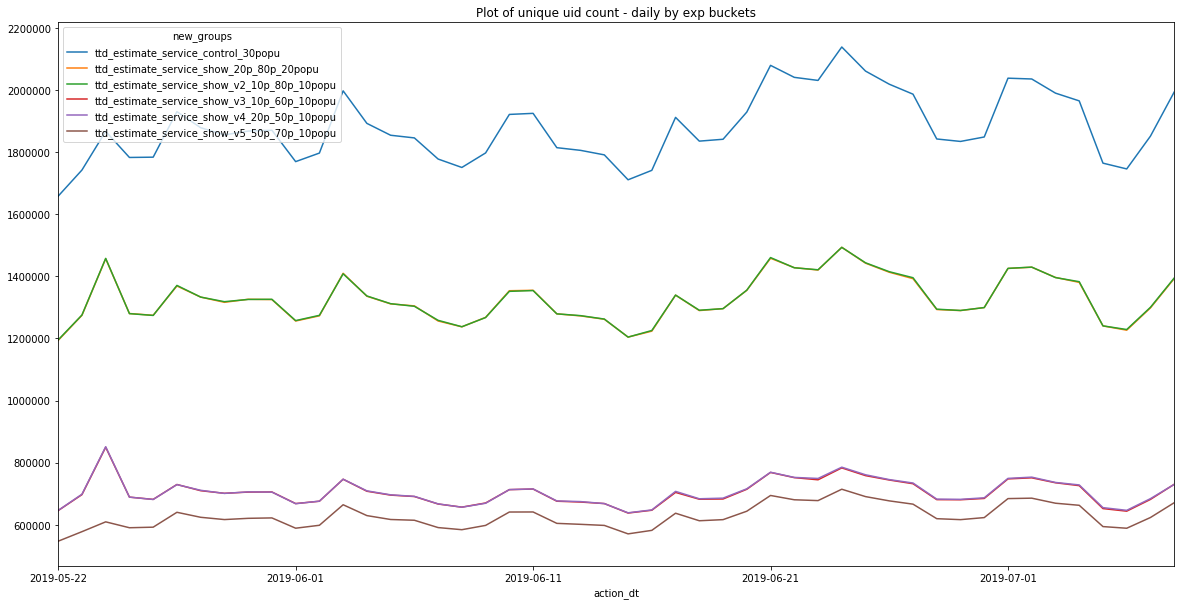

In [95]:
df_uid_dt.pivot_table(columns='new_groups', values='unique_uid_count', index='action_dt').plot(figsize=(20, 10))
plt.title('Plot of unique uid count - daily by exp buckets')

In [106]:
show_groups = ['ttd_estimate_service_show_20p_80p_20popu','ttd_estimate_service_show_v2_10p_80p_10popu',\
               'ttd_estimate_service_show_v3_10p_60p_10popu','ttd_estimate_service_show_v4_20p_50p_10popu','ttd_estimate_service_show_v5_50p_70p_10popu']
exp_p = [0.2,0.2,0.1,0.1,0.1]
metrics = 'unique_uid_count'
for (group,p) in zip(show_groups,exp_p): 
    check_balance(df_uid,group,metrics,p)

Bucket of ttd_estimate_service_show_20p_80p_20popu is NOT really Balanced
Because the theoretical 95% CI of group population should be [0.19990784382800963,0.2000921561719904], BUT the empirical group population is 0.2008724914857682
----------------------------------------------------------------------------------------------------
Bucket of ttd_estimate_service_show_v2_10p_80p_10popu is NOT really Balanced
Because the theoretical 95% CI of group population should be [0.19990784382800963,0.2000921561719904], BUT the empirical group population is 0.20084447041812573
----------------------------------------------------------------------------------------------------
Bucket of ttd_estimate_service_show_v3_10p_60p_10popu is NOT really Balanced
Because the theoretical 95% CI of group population should be [0.09993088287100721,0.1000691171289928], BUT the empirical group population is 0.10286531168131988
----------------------------------------------------------------------------------------

# CR overall plot

## dpd to buy CR

Text(0.5,1,'Plot of all groups togather - dpd to buy CR')

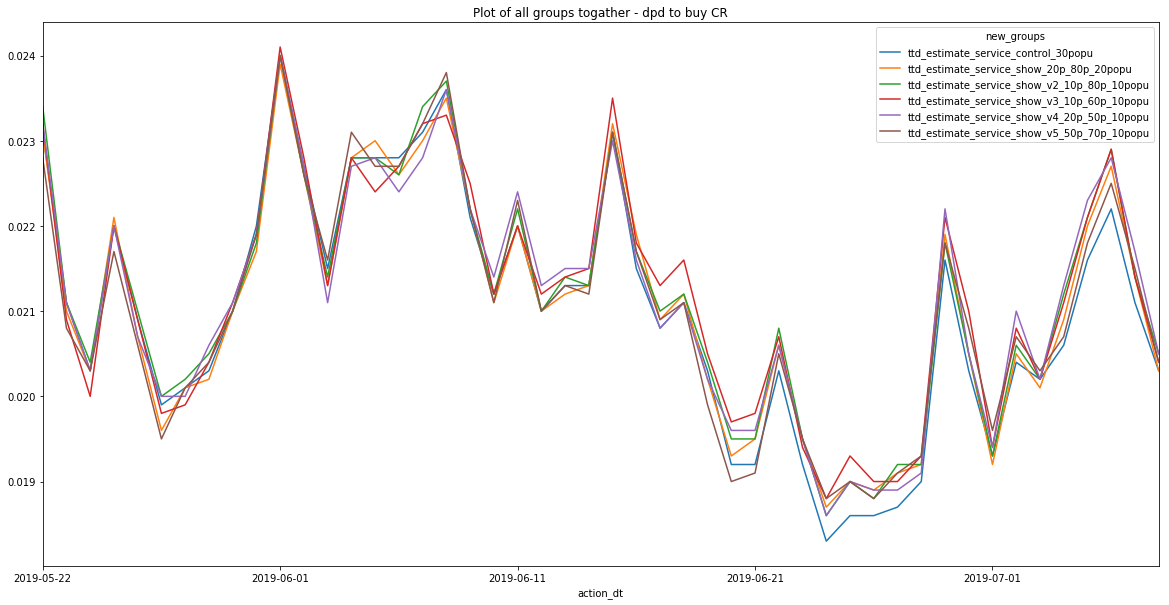

In [20]:
df_cr[['action_dt','new_groups','dpd_cr_imp_based']].pivot_table(columns='new_groups', values='dpd_cr_imp_based', index='action_dt').plot(figsize=(20, 10))
plt.title('Plot of all groups togather - dpd to buy CR')

### each group VS control group

In [38]:
show_groups = ['ttd_estimate_service_show_20p_80p_20popu','ttd_estimate_service_show_v2_10p_80p_10popu','ttd_estimate_service_show_v3_10p_60p_10popu',\
               'ttd_estimate_service_show_v4_20p_50p_10popu','ttd_estimate_service_show_v5_50p_70p_10popu']

In [36]:
set(df_cr.new_groups)

{'ttd_estimate_service_control_30popu',
 'ttd_estimate_service_show_20p_80p_20popu',
 'ttd_estimate_service_show_v2_10p_80p_10popu',
 'ttd_estimate_service_show_v3_10p_60p_10popu',
 'ttd_estimate_service_show_v4_20p_50p_10popu',
 'ttd_estimate_service_show_v5_50p_70p_10popu'}

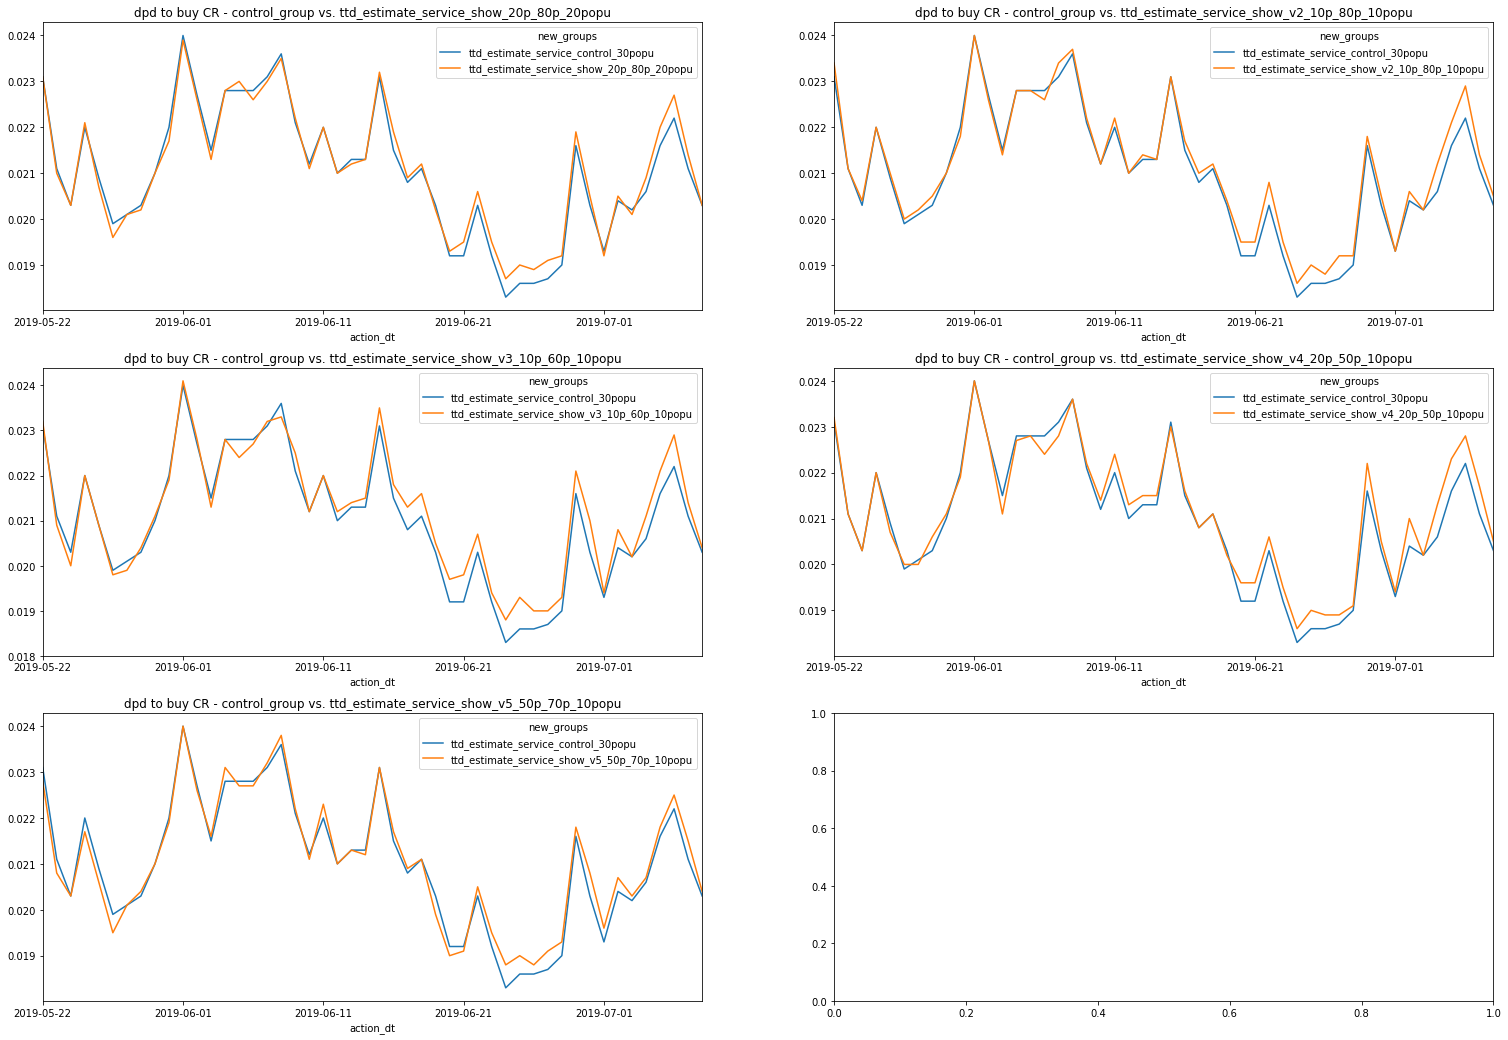

In [37]:
m = 2
n = (len(show_groups)+1) // m

fig, axes = plt.subplots(n, m, figsize=(m*13, n*6))

for i in range(len(show_groups)):
    x = i//m
    y = i%m
    
    mask = df_cr.new_groups.isin(['ttd_estimate_service_control_30popu',show_groups[i]])

    df_cr.loc[mask,['action_dt','new_groups','dpd_cr_imp_based']].pivot_table(columns='new_groups', values='dpd_cr_imp_based', index='action_dt')\
    .plot(ax=axes[x][y], title='dpd to buy CR - control_group vs. {}'.format(show_groups[i]))

## a2c to buy CR

Text(0.5,1,'Plot of all groups togather - a2c to buy CR')

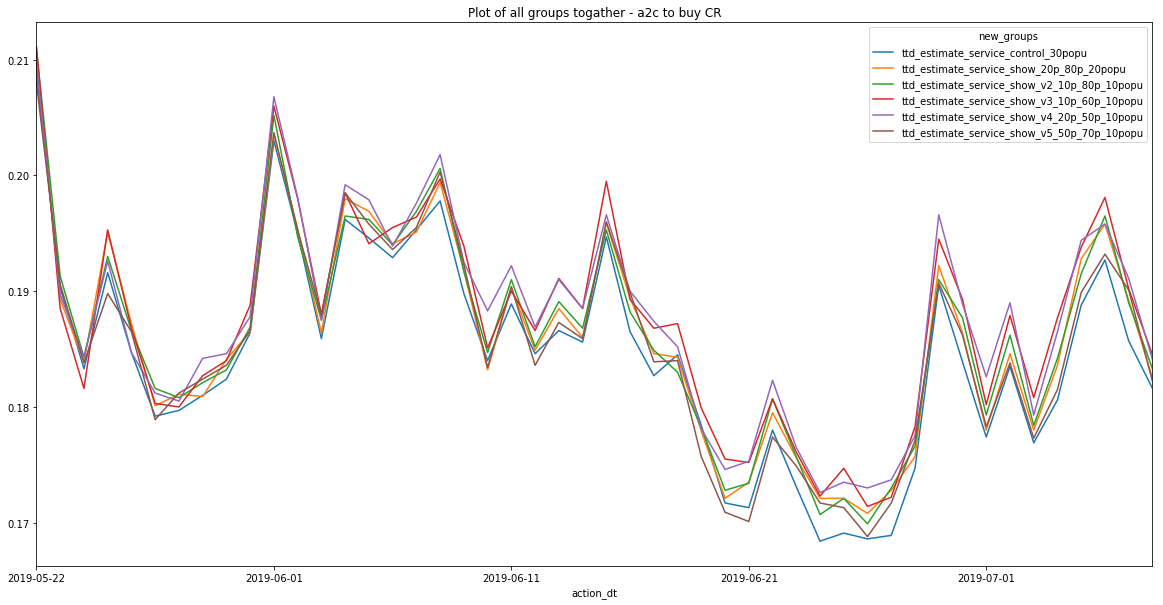

In [21]:
df_cr[['action_dt','new_groups','a2c_cr_imp_based']].pivot_table(columns='new_groups', values='a2c_cr_imp_based', index='action_dt').plot(figsize=(20, 10))
plt.title('Plot of all groups togather - a2c to buy CR')

### each group VS control group

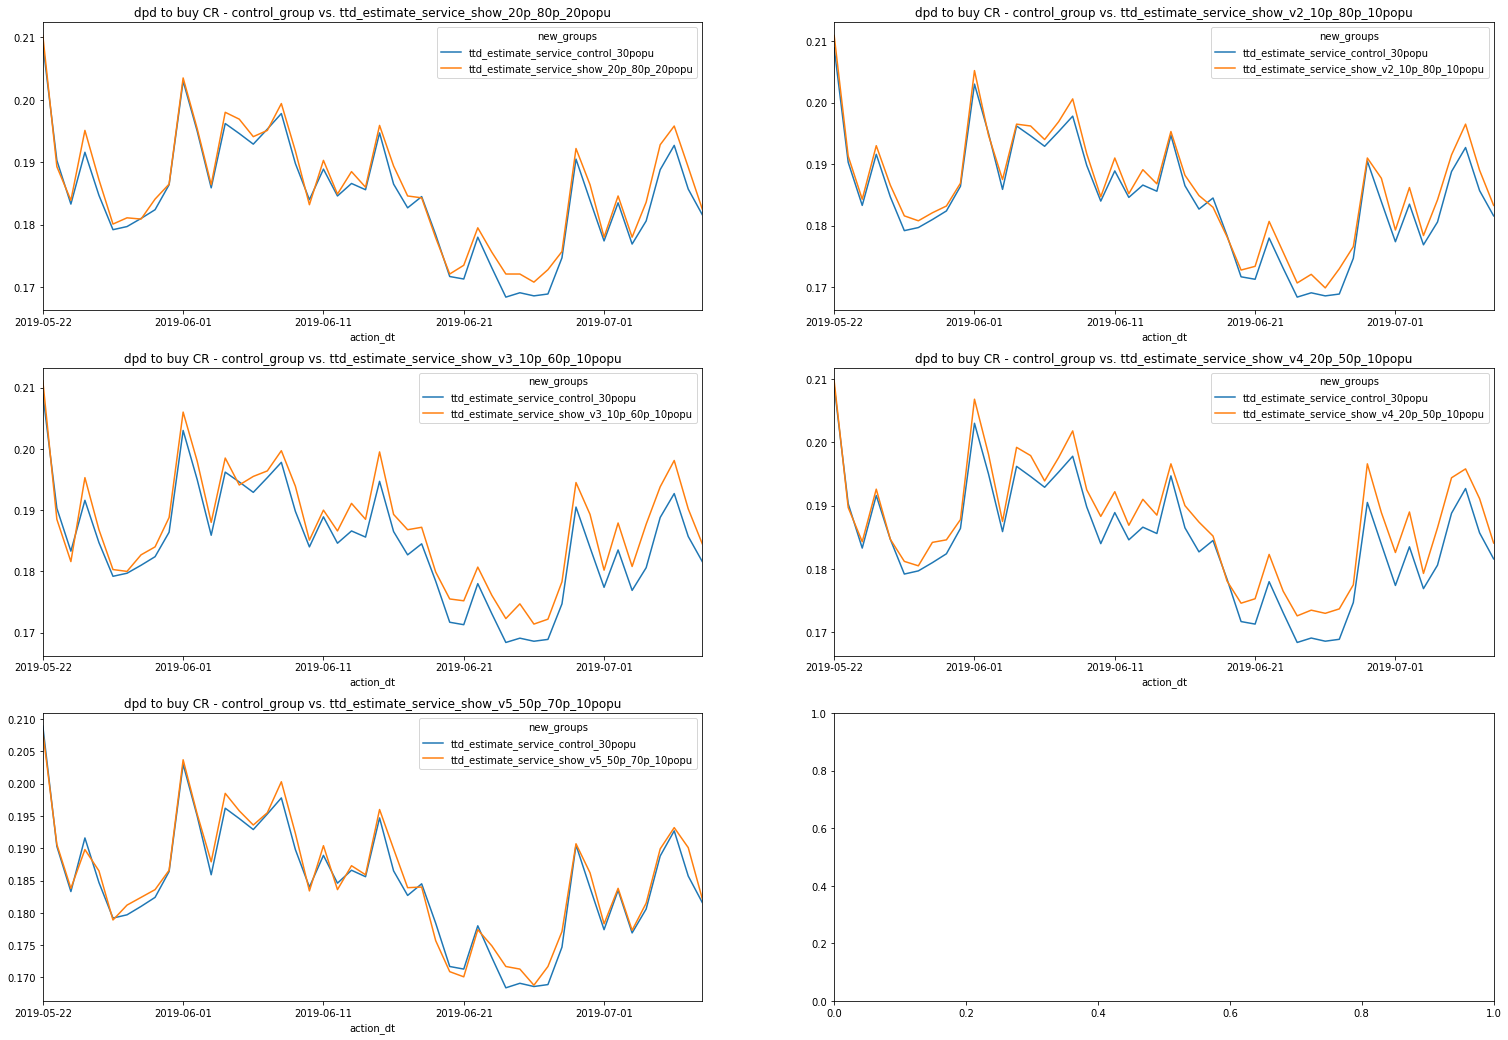

In [39]:
m = 2
n = (len(show_groups)+1) // m

fig, axes = plt.subplots(n, m, figsize=(m*13, n*6))

for i in range(len(show_groups)):
    x = i//m
    y = i%m
    
    mask = df_cr.new_groups.isin(['ttd_estimate_service_control_30popu',show_groups[i]])

    df_cr.loc[mask,['action_dt','new_groups','a2c_cr_imp_based']].pivot_table(columns='new_groups', values='a2c_cr_imp_based', index='action_dt')\
    .plot(ax=axes[x][y], title='dpd to buy CR - control_group vs. {}'.format(show_groups[i]))

## Check sample balance

In [40]:
df_cr.head()

,groups,new_groups,action_dt,impression_contest_imp_based,click_commerce_add_to_cart_imp_based,click_buy_button_imp_based,dpd_cr_imp_based,a2c_cr_imp_based,userid_count,dpd_cr_userid_based,a2c_cr_userid_based,dpd_cr_stddev_userid_based,a2c_cr_stddev_userid_based
0,ttd_estimate_service_control,ttd_estimate_service_control_30popu,2019-05-22,17126337,1892103,395348,0.0231,0.2089,1658736,0.0306,0.0788,0.2149,0.3853
1,ttd_estimate_service_control,ttd_estimate_service_control_30popu,2019-05-23,19280050,2134599,406141,0.0211,0.1903,1742753,0.0273,0.0732,0.1940,0.3528
2,ttd_estimate_service_control,ttd_estimate_service_control_30popu,2019-05-24,19790863,2195459,402370,0.0203,0.1833,1867417,0.0260,0.0686,0.1913,0.3484
3,ttd_estimate_service_control,ttd_estimate_service_control_30popu,2019-05-25,19045374,2183634,418375,0.0220,0.1916,1783269,0.0284,0.0728,0.2046,0.3607
4,ttd_estimate_service_control,ttd_estimate_service_control_30popu,2019-05-26,20228430,2293040,423490,0.0209,0.1847,1784191,0.0268,0.0722,0.1862,0.3505


### impressionve balance

In [103]:
def check_balance(df,group_name,metrics_name,expected_pop):
    mean = expected_pop
    var = expected_pop*(1-expected_pop)
    z95 = 1.96

    N = df[metrics_name].sum()

    mask = df.new_groups==group_name
    n = df.loc[mask,metrics_name].sum()

    p_hat = n/N

    sd = np.sqrt(var/N)
    margin = z95*sd

    upper = expected_pop + margin
    lower = expected_pop - margin

    if (upper>=p_hat) & (lower<=p_hat):
        print('Bucket of {} is Balanced'.format(group_name))
        print('Because the theoretical 95% CI of group population should be [{},{}], and the empirical group population is {}'.format(lower,upper,p_hat))
    else:
        print('Bucket of {} is NOT really Balanced'.format(group_name)) 
        print('Because the theoretical 95% CI of group population should be [{},{}], BUT the empirical group population is {}'.format(lower,upper,p_hat))
    print(100*'-')

In [104]:
show_groups = ['ttd_estimate_service_show_20p_80p_20popu','ttd_estimate_service_show_v2_10p_80p_10popu','ttd_estimate_service_show_v3_10p_60p_10popu',\
               'ttd_estimate_service_show_v4_20p_50p_10popu','ttd_estimate_service_show_v5_50p_70p_10popu']
exp_p = [0.2,0.1,0.1,0.1,0.1,0.1]

for (group,p) in zip(show_groups,exp_p): 
    check_balance(df_cr,group,'impression_contest_imp_based',p)

Bucket of ttd_estimate_service_show_20p_80p_20popu is NOT really Balanced
Because the theoretical 95% CI of group population should be [0.19998670264457313,0.2000132973554269], BUT the empirical group population is 0.20237818256001297
----------------------------------------------------------------------------------------------------
Bucket of ttd_estimate_service_show_v2_10p_80p_10popu is NOT really Balanced
Because the theoretical 95% CI of group population should be [0.09999002698342986,0.10000997301657015], BUT the empirical group population is 0.2022170200527608
----------------------------------------------------------------------------------------------------
Bucket of ttd_estimate_service_show_v3_10p_60p_10popu is NOT really Balanced
Because the theoretical 95% CI of group population should be [0.09999002698342986,0.10000997301657015], BUT the empirical group population is 0.10781841495764354
--------------------------------------------------------------------------------------

In [105]:
show_groups = ['ttd_estimate_service_show_20p_80p_20popu','ttd_estimate_service_show_v2_10p_80p_10popu','ttd_estimate_service_show_v3_10p_60p_10popu',\
               'ttd_estimate_service_show_v4_20p_50p_10popu','ttd_estimate_service_show_v5_50p_70p_10popu']
exp_p = [0.2,0.1,0.1,0.1,0.1,0.1]

for (group,p) in zip(show_groups,exp_p): 
    check_balance(df_cr,group,'click_commerce_add_to_cart_imp_based',p)

Bucket of ttd_estimate_service_show_20p_80p_20popu is NOT really Balanced
Because the theoretical 95% CI of group population should be [0.1999604974775425,0.20003950252245753], BUT the empirical group population is 0.20205043598042405
----------------------------------------------------------------------------------------------------
Bucket of ttd_estimate_service_show_v2_10p_80p_10popu is NOT really Balanced
Because the theoretical 95% CI of group population should be [0.09997037310815687,0.10002962689184314], BUT the empirical group population is 0.2024590455306399
----------------------------------------------------------------------------------------------------
Bucket of ttd_estimate_service_show_v3_10p_60p_10popu is NOT really Balanced
Because the theoretical 95% CI of group population should be [0.09997037310815687,0.10002962689184314], BUT the empirical group population is 0.10745689098160616
--------------------------------------------------------------------------------------

## Simple power(80% & 90%) analysis: min sample size

In [150]:
def simple_power_sample_size(row,beta=0.8):
    var = row[0]*(1-row[0])
    effect_size = row[1]
    
    if effect_size != 0: 
        if beta == 0.8:
            n = math.ceil(16*var/(effect_size*effect_size))
        elif beta == 0.9:
            n = math.ceil(21*var/(effect_size*effect_size))
        else:
            n= np.nan
            print('beta need to be either 0.8 or 0.9, and 0.8 is the default value')
    elif effect_size == 0:
        n= np.nan
        print('effect size can NOT be 0 !')
    return n

In [159]:
df_cr.head()

,groups,new_groups,action_dt,impression_contest_imp_based,click_commerce_add_to_cart_imp_based,click_buy_button_imp_based,dpd_cr_imp_based,a2c_cr_imp_based,userid_count,dpd_cr_userid_based,a2c_cr_userid_based,dpd_cr_stddev_userid_based,a2c_cr_stddev_userid_based
0,ttd_estimate_service_control,ttd_estimate_service_control_30popu,2019-05-22,17126337,1892103,395348,0.0231,0.2089,1658736,0.0306,0.0788,0.2149,0.3853
1,ttd_estimate_service_control,ttd_estimate_service_control_30popu,2019-05-23,19280050,2134599,406141,0.0211,0.1903,1742753,0.0273,0.0732,0.1940,0.3528
2,ttd_estimate_service_control,ttd_estimate_service_control_30popu,2019-05-24,19790863,2195459,402370,0.0203,0.1833,1867417,0.0260,0.0686,0.1913,0.3484
3,ttd_estimate_service_control,ttd_estimate_service_control_30popu,2019-05-25,19045374,2183634,418375,0.0220,0.1916,1783269,0.0284,0.0728,0.2046,0.3607
4,ttd_estimate_service_control,ttd_estimate_service_control_30popu,2019-05-26,20228430,2293040,423490,0.0209,0.1847,1784191,0.0268,0.0722,0.1862,0.3505


In [155]:
df_cr_group =  df_cr.groupby('new_groups',as_index=False)['impression_contest_imp_based','click_commerce_add_to_cart_imp_based','click_buy_button_imp_based'].sum()
df_cr_group['imp_cr'] = df_cr_group.click_buy_button_imp_based/df_cr_group.impression_contest_imp_based
df_cr_group['a2c_cr'] = df_cr_group.click_buy_button_imp_based/df_cr_group.click_commerce_add_to_cart_imp_based

imp_cr_control = df_cr_group.loc[df_cr_group.new_groups=='ttd_estimate_service_control_30popu','imp_cr']
a2c_cr_control = df_cr_group.loc[df_cr_group.new_groups=='ttd_estimate_service_control_30popu','a2c_cr']

df_cr_group['imp_cr_effect_size'] = df_cr_group.apply(lambda row: row['imp_cr']-imp_cr_control,axis=1)
df_cr_group['a2c_cr_effect_size'] = df_cr_group.apply(lambda row: row['a2c_cr']-a2c_cr_control,axis=1)

df_cr_group['pdp_min_sample_size']= df_cr_group[['imp_cr','imp_cr_effect_size']].apply(simple_power_sample_size,axis=1)
df_cr_group['a2c_min_sample_size']= df_cr_group[['a2c_cr','a2c_cr_effect_size']].apply(simple_power_sample_size,axis=1)

    

effect size can NOT be 0 !
effect size can NOT be 0 !


In [156]:
df_cr_group

,new_groups,impression_contest_imp_based,click_commerce_add_to_cart_imp_based,click_buy_button_imp_based,imp_cr,a2c_cr,imp_cr_effect_size,a2c_cr_effect_size,pdp_min_sample_size,a2c_min_sample_size
0,ttd_estimate_service_control_30popu,987193157,112233656,20683279,0.020952,0.184288,0.000000,0.000000,NaN,NaN
1,ttd_estimate_service_show_20p_80p_20popu,703501880,79587023,14789140,0.021022,0.185824,0.000071,0.001536,66114677.0,1026236.0
2,ttd_estimate_service_show_v2_10p_80p_10popu,702941651,79747973,14838282,0.021109,0.186065,0.000157,0.001777,13372581.0,767342.0
3,ttd_estimate_service_show_v3_10p_60p_10popu,374795626,42326927,7923823,0.021142,0.187205,0.000190,0.002918,9161194.0,286005.0
4,ttd_estimate_service_show_v4_20p_50p_10popu,376787990,42424772,7951862,0.021104,0.187434,0.000153,0.003147,14168920.0,246098.0
5,ttd_estimate_service_show_v5_50p_70p_10popu,330954208,37576463,6957557,0.021023,0.185157,0.000071,0.000870,65111418.0,3191912.0


## Chi-Square Test

In [193]:
def chi_2_test(df,treatment_name,control_name,imp,clk):
    treatment_clk = df.loc[df['new_groups']==treatment_name,clk].sum()
    treatment_noclk = df.loc[df['new_groups']==treatment_name,imp].sum() - df.loc[df['new_groups']==treatment_name,clk].sum()
    
    control_clk = df.loc[df['new_groups']==control_name,clk].sum()
    control_noclk = df.loc[df['new_groups']==control_name,imp].sum() - df.loc[df['new_groups']==control_name,clk].sum()
    
    contingency_table = np.array([[control_clk, control_noclk], [treatment_clk, treatment_noclk]])
    
    chi2, p, dof, expected = chi2_contingency(contingency_table, correction=False)
    
    return chi2,p;

In [194]:
df_cr.head()

,groups,new_groups,action_dt,impression_contest_imp_based,click_commerce_add_to_cart_imp_based,click_buy_button_imp_based,dpd_cr_imp_based,a2c_cr_imp_based,userid_count,dpd_cr_userid_based,a2c_cr_userid_based,dpd_cr_stddev_userid_based,a2c_cr_stddev_userid_based
0,ttd_estimate_service_control,ttd_estimate_service_control_30popu,2019-05-22,17126337,1892103,395348,0.0231,0.2089,1658736,0.0306,0.0788,0.2149,0.3853
1,ttd_estimate_service_control,ttd_estimate_service_control_30popu,2019-05-23,19280050,2134599,406141,0.0211,0.1903,1742753,0.0273,0.0732,0.1940,0.3528
2,ttd_estimate_service_control,ttd_estimate_service_control_30popu,2019-05-24,19790863,2195459,402370,0.0203,0.1833,1867417,0.0260,0.0686,0.1913,0.3484
3,ttd_estimate_service_control,ttd_estimate_service_control_30popu,2019-05-25,19045374,2183634,418375,0.0220,0.1916,1783269,0.0284,0.0728,0.2046,0.3607
4,ttd_estimate_service_control,ttd_estimate_service_control_30popu,2019-05-26,20228430,2293040,423490,0.0209,0.1847,1784191,0.0268,0.0722,0.1862,0.3505


In [202]:
show_groups = ['ttd_estimate_service_show_20p_80p_20popu','ttd_estimate_service_show_v2_10p_80p_10popu','ttd_estimate_service_show_v3_10p_60p_10popu',\
               'ttd_estimate_service_show_v4_20p_50p_10popu','ttd_estimate_service_show_v5_50p_70p_10popu']
for group in show_groups:
    (chi2, p) = chi_2_test(df=df_cr,treatment_name=group,control_name='ttd_estimate_service_control_30popu',imp='impression_contest_imp_based',clk='click_buy_button_imp_based')
    print('the p-value of chi-square test of treatment group - "{}", is {}'.format(group,p))
    if p <= 0.05:
        print('which means there is a significant difference between control and "{}" groups'.format(group))
    else:
        print('which means there is no significant evidence to support differece between control and {} groups'.format(group))
    print(100*'_')
    print('\n')

the p-value of chi-square test of treatment group - "ttd_estimate_service_show_20p_80p_20popu", is 1.8653166903243946e-23
which means there is a significant difference between control and "ttd_estimate_service_show_20p_80p_20popu" groups
____________________________________________________________________________________________________


the p-value of chi-square test of treatment group - "ttd_estimate_service_show_v2_10p_80p_10popu", is 2.6561559391880325e-109
which means there is a significant difference between control and "ttd_estimate_service_show_v2_10p_80p_10popu" groups
____________________________________________________________________________________________________


the p-value of chi-square test of treatment group - "ttd_estimate_service_show_v3_10p_60p_10popu", is 7.491831560795523e-106
which means there is a significant difference between control and "ttd_estimate_service_show_v3_10p_60p_10popu" groups
___________________________________________________________________

## T-Test

## With Bonferroni Correction